In [10]:
import os
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "v1"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, RepeatVector, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model


# CSV 파일에서 데이터 읽기
df = pd.read_csv('NVspinData_None_-1_230807.csv')

# 데이터셋 분리 - train_set(train+validation) 8 : test_set 2
train_set, test_set = train_test_split(df, shuffle=True, test_size=0.2)

# df.info()
# train_set.info()
# test_set.info()
# train_set.head()
# test_set.head()
# df.plot(kind = "scatter", x="Theta", y="Phi", alpha=0.3)

# train_set 데이터 전처리 (train+validation)
theta_tv = train_set['Theta'].values.reshape(-1, 1)
phi_tv = train_set['Phi'].values.reshape(-1, 1)
sequence_tv = train_set['combination'].apply(eval).to_list()
max_seq_length_tv = max(len(seq) for seq in sequence_tv)
sequence_padded_tv = pad_sequences(sequence_tv, maxlen=max_seq_length_tv)

# test_set 데이터 전처리 (final_test)
theta_test = test_set['Theta'].values.reshape(-1, 1)
phi_test = test_set['Phi'].values.reshape(-1, 1)
sequence_test = test_set['combination'].apply(eval).to_list()
max_seq_length_test = max(len(seq) for seq in sequence_test)
sequence_padded_test = pad_sequences(sequence_test, maxlen=max_seq_length_test)

In [12]:
# 모델 구성
# Input : 입력 텐서 반환
theta_input = Input(shape=(1,), name='theta_input')
phi_input = Input(shape=(1,), name='phi_input')
sequence_input = Input(shape=(max_seq_length_tv,), name='sequence_input')

# RepeatVector : sequence와 동일한 길이로 확장
# 각 시퀀스의 모든 단계(원소 스텝 = 타임 스텝)에서 동일한 theta와 phi 값 반복 사용
theta_repeated = RepeatVector(max_seq_length_tv, name='theta_repeated')(theta_input)
phi_repeated = RepeatVector(max_seq_length_tv, name='phi_repeated')(phi_input)
# Embedding : 시퀀스 내의 각 숫자(최대 정수 값 +1 = 5)를 32차원 벡터로 변환
sequence_embedding = Embedding(5, 32, input_length=max_seq_length_tv, name='sequence_embedding')(sequence_input)

# Concatenate : 입력을 연결, 여러 입력 정보 합침
# 입력 레이어 - Input들 합침
concat_layer = Concatenate(name='concat_layer')([theta_repeated, phi_repeated, sequence_embedding])
# RNN 레이어 1
rnn_layer = SimpleRNN(32, return_sequences=True, name='rnn_layer1')(concat_layer)
# RNN 레이어 2
rnn_layer2 = SimpleRNN(64, return_sequences=True, name='rnn_layer2')(rnn_layer)
# RNN 레이어 3
rnn_layer3 = SimpleRNN(128, return_sequences=True, name='rnn_layer3')(rnn_layer2)
# RNN 레이어 4
rnn_layer4 = SimpleRNN(128, return_sequences=True, name='rnn_layer4')(rnn_layer3)
# RNN 레이어 5
rnn_layer5 = SimpleRNN(128, return_sequences=True, name='rnn_layer5')(rnn_layer4)
# RNN 레이어 6
rnn_layer6 = SimpleRNN(128, return_sequences=True, name='rnn_layer6')(rnn_layer5)
# TimeDistributed : Dense 레이어를 각 시간 단계에 독립적으로 적용, 시퀀스의 각 시간 단계에서 동일한 Dense 레이어가 적용
# ... 시퀀스의 각 시간 단계를 독립적으로 예측 가능
# Dense : 출력 뉴런 5개(= 출력 공간 차원), softmax 활성화 함수 사용하는 Dense layer
# 출력 레이어
output = TimeDistributed(Dense(5, activation='softmax'), name='output_layer')(rnn_layer6)

# rnn_layer = SimpleRNN(32, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(concat_layer)
# rnn_layer2 = SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))(rnn_layer)
# dropout_layer = Dropout(0.5)(rnn_layer2)
# output = TimeDistributed(Dense(5, activation='softmax'))(dropout_layer)

my_model = Model(inputs=[theta_input, phi_input, sequence_input], outputs=output)
print(my_model.summary())
plot_model(my_model, show_shapes=True)

# Compiler        
optimizer = Adam(learning_rate=0.00001)
# optimizer = RMSprop()
my_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 데이터셋 분리 train_set 8 : validation_set 2
sequence_train, sequence_val, theta_train, theta_val, phi_train, phi_val = train_test_split(sequence_padded_tv, theta_tv, phi_tv, test_size=0.2)

history = my_model.fit(
    {'theta_input': theta_train, 'phi_input': phi_train, 'sequence_input': sequence_train},
    np.expand_dims(sequence_train, -1), 
    validation_data=({'theta_input': theta_val, 'phi_input': phi_val, 
                        'sequence_input': sequence_val}, np.expand_dims(sequence_val, -1)), epochs=70, batch_size=16)
                        # callbacks=[LearningRateScheduler(lr_schedule)]
# batch 16개로 나누어 70 epoch 만큼 반복

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 theta_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 phi_input (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 sequence_input (InputLayer  [(None, 35)]                 0         []                            
 )                                                                                                
                                                                                                  
 theta_repeated (RepeatVect  (None, 35, 1)                0         ['theta_input[0][0]']   

그림 저장: RNN_model_loss


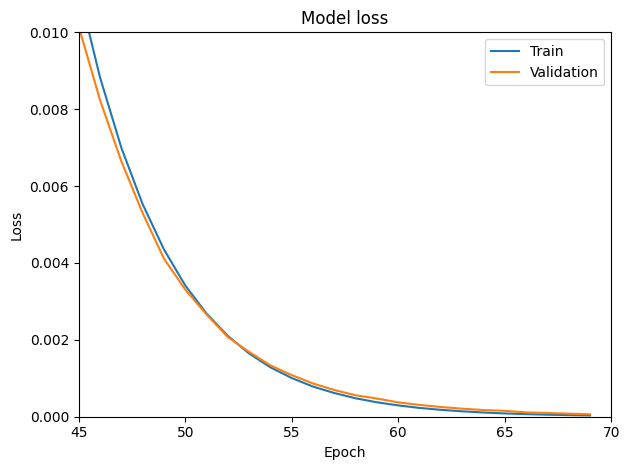

그림 저장: RNN_model_accuracy


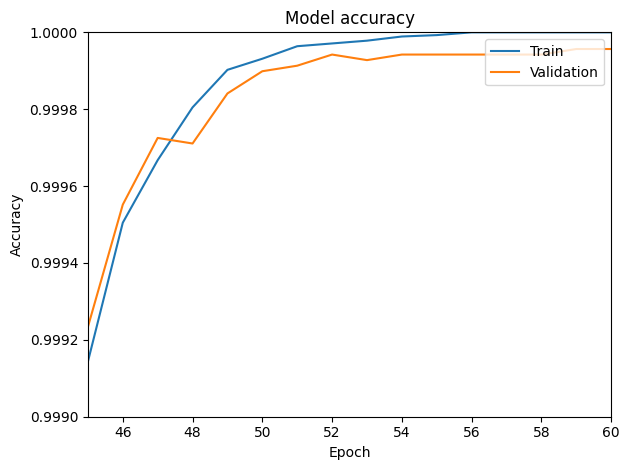

78/78 [==============================] - 1s 10ms/step - loss: 3.5500e-05 - accuracy: 1.0000
Test Accuracy: 100.00
Test Loss: 0.00


In [33]:
# my_model.summary()
# my_model.predict({'theta_input': theta_t, 'phi_input': phi_t, 'sequence_input': seq_t})

def plot_history(history):
         # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.axis([45, 70, 0, 0.01])
        plt.legend(['Train', 'Validation'], loc='upper right')
        save_fig("RNN_model_loss")
        plt.show()

        # Plot training & validation accuracy values
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.axis([45, 60, 0.999, 1.0])
        plt.legend(['Train', 'Validation'], loc='upper right')
        save_fig("RNN_model_accuracy")
        plt.show()

def evaluate(model, theta, phi, sequence):
    loss, acc = model.evaluate({'theta_input': theta, 'phi_input': phi, 'sequence_input': sequence}, np.expand_dims(sequence, -1))
    print("Test Accuracy: {:.2f}".format(acc*100))
    print("Test Loss: {:.2f}".format(loss*100))

# 결과 그래프 그리기
plot_history(history)

# 모델 성능 평가
evaluate(my_model, theta_test, phi_test, sequence_padded_test)

In [ ]:
# 새로운 theta, phi 값에 대한 sequence 예측
new_theta = np.array([[1.03300026]])   # 새로운 theta 값
new_phi = np.array([[5.57917372]])     # 새로운 phi 값
# 'new_sequence'의 길이를 35로 맞추기
new_sequence = np.zeros((1, 35))  # shape (1, 35)의 0으로 이루어진 배열 생성

predicted_sequence = my_model.predict({
    'theta_input': new_theta, 
    'phi_input': new_phi, 
    'sequence_input': new_sequence
})

# 가장 확률이 높은 sequence만 출력
predicted_sequence2 = np.argmax(predicted_sequence, axis=-1)
print(predicted_sequence2)

In [ ]:
# # 테스트 세트에 대한 리스트 예측
# predicted_sequence = rnn_model.my_predict(0.944681, 3.507593, [1, 3, 3, 2, 2, 4, 1, 1, 3, 0, 4])

# # 첫 10개의 예측된 시퀀스 출력
# for i in range(10):
#     print(f"True sequence: {sequence_test[i]}")
#     print(f"Predicted sequence: {np.argmax(predicted_sequence[i], axis=1)}\n")